# Getting started with sar_snowmelt_timing

## Imports

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import rasterio as rio
import glob
import re
import xarray as xr
import rioxarray as rxr
sys.path.append('../sar_snowmelt_timing')
import s1_rtc_bs_utils

## I recommend microsoft planetary computer because of easy dask gateway integration (beyond a lot of other good reasons). Comment out the next cell if you're not on mpc!

In [2]:
import dask_gateway
cluster = dask_gateway.GatewayCluster(shutdown_on_close=False)
client = cluster.get_client()
cluster.adapt(minimum=10, maximum=100)
print(client.dashboard_link)

https://pccompute.westeurope.cloudapp.azure.com/compute/services/dask-gateway/clusters/prod.c2dcb1a5af4946cb8c91ce6d7aaa51ad/status


## Read in an AOI geojson and define our time period of interest

In [3]:
bbox_gdf = gpd.read_file('../input/shapefiles/mt_rainier.geojson')
start_time = '2014-01-01'
end_time = '2023-12-31'

## Use get_s1_rtc_stac_pc() to get sentinel-1 data over our AOI

In [4]:
ts_ds = s1_rtc_bs_utils.get_s1_rtc_stac_pc(bbox_gdf,start_time=start_time,end_time=end_time,polarization='all',resolution=20)

/srv/conda/envs/notebook/lib/python3.11/site-packages/stackstac/prepare.py:363: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


In [5]:
ts_ds

<xarray.DataArray 'stackstac-f7b68656dbb35b6d06a7ddb1bdec9b67' (time: 876,
                                                                band: 2,
                                                                y: 881, x: 889)>
dask.array<getitem, shape=(876, 2, 881, 889), dtype=float32, chunksize=(1, 1, 511, 511), chunktype=numpy.ndarray>
Coordinates: (12/39)
  * time                                   (time) datetime64[ns] 2014-10-13T1...
    id                                     (time) <U66 'S1A_IW_GRDH_1SSV_2014...
  * band                                   (band) <U2 'vv' 'vh'
  * x                                      (x) float64 5.858e+05 ... 6.036e+05
  * y                                      (y) float64 5.2e+06 ... 5.183e+06
    sar:center_frequency                   float64 5.405
    ...                                     ...
    sat:orbit_state                        (time) <U10 'descending' ... 'asce...
    sat:relative_orbit                     (time) int64 115 64 115 ... 64 137
    title                                  (band) <U41 'VV: vertical transmit...
    description                            (band) <U173 'Terrain-corrected ga...
    raster:bands                           object {'nodata': -32768, 'data_ty...
    epsg                                   int64 32610
Attributes:
    spec:        RasterSpec(epsg=32610, bounds=(585780, 5182800, 603580, 5200...
    crs:         epsg:32610
    transform:   | 20.00, 0.00, 585780.00|\n| 0.00,-20.00, 5200440.00|\n| 0.0...
    resolution:  20

## Let's convert to dB to visualize the vv polarization for one relative orbit for one year

In [6]:
ts_ds_db = 10*np.log10(ts_ds)

In [7]:
ts_ds_db_vv_orbit137 = ts_ds_db[ts_ds_db['sat:relative_orbit']==137].sel(band='vv').sel(time=slice('2020-01-01','2020-12-31'))

/tmp/ipykernel_3258/1216520391.py:2: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax, title in zip(vis.axes.flat, pd.to_datetime(ts_ds_db_vv_orbit137.time)):


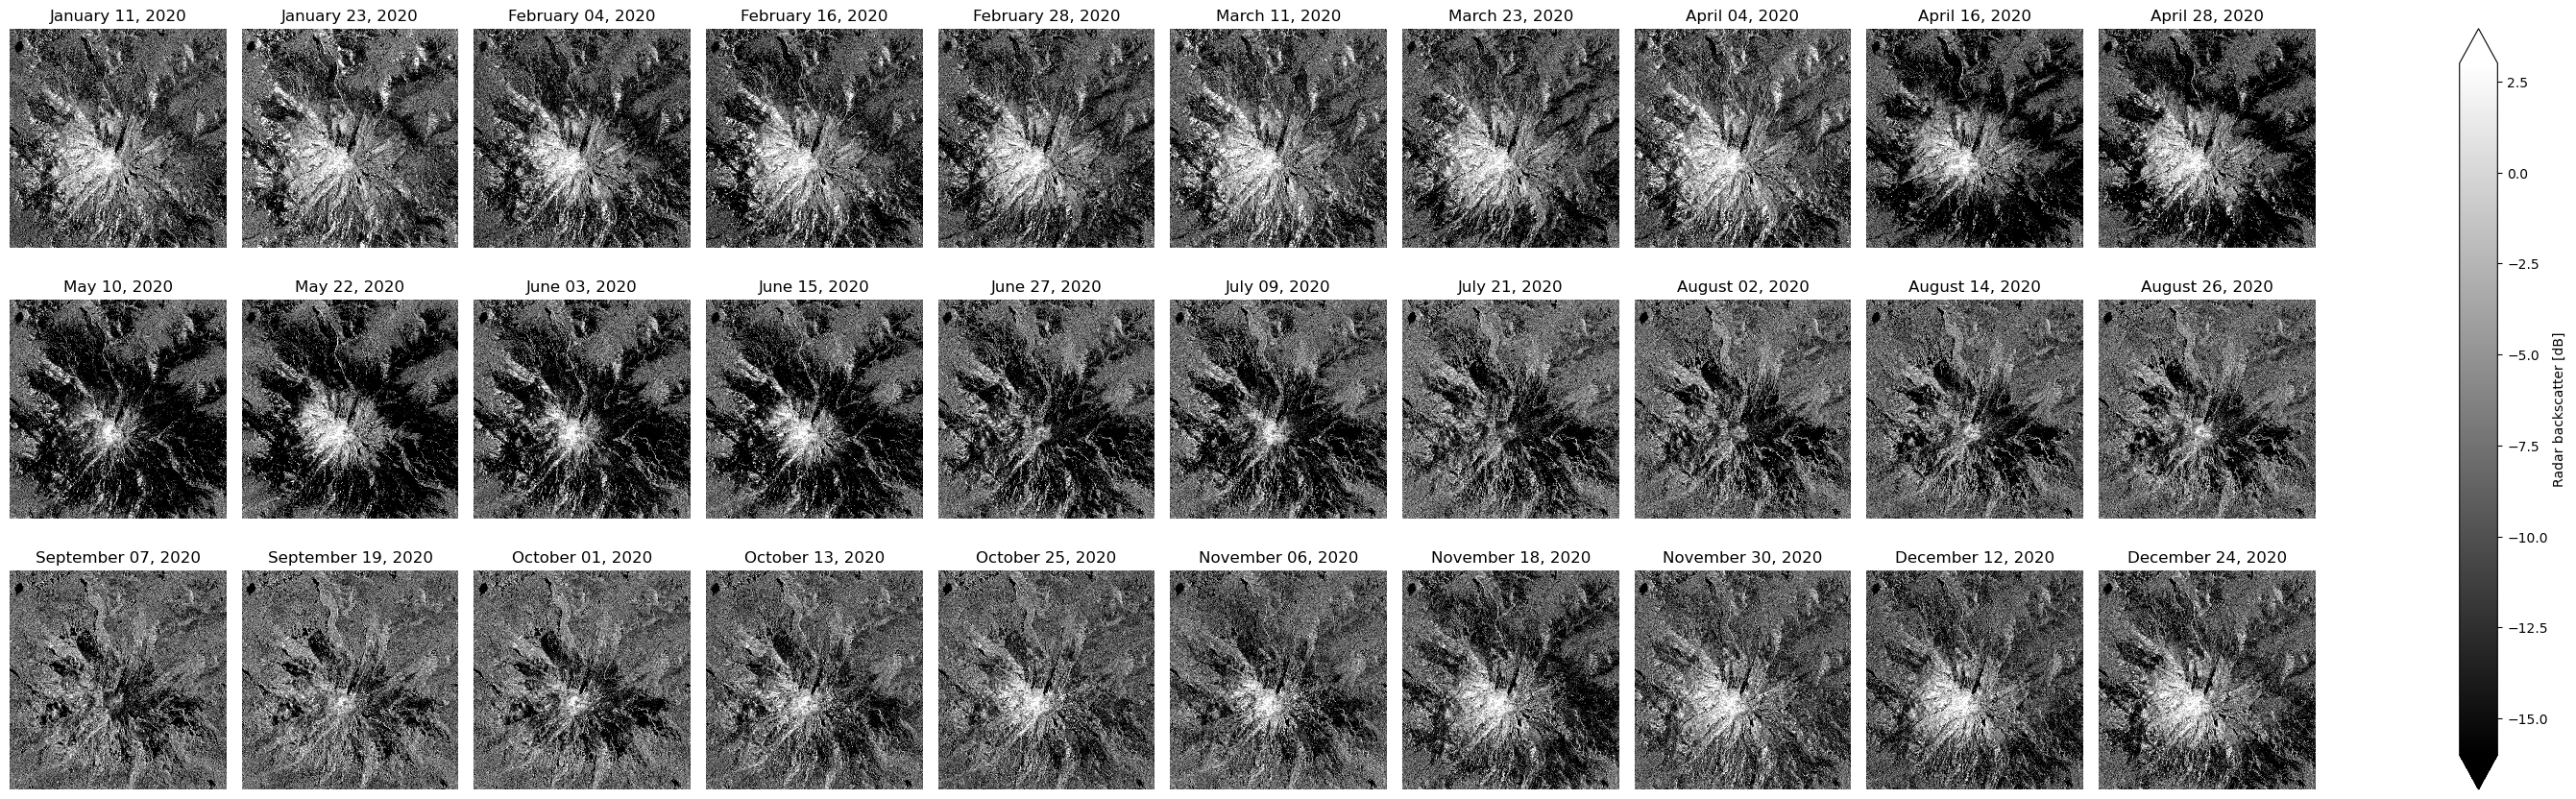

In [8]:
vis = ts_ds_db_vv_orbit137.plot(col='time',col_wrap=10,cmap='gray',vmin=-16,vmax=3,cbar_kwargs={"label": "Radar backscatter [dB]"})
for ax, title in zip(vis.axes.flat, pd.to_datetime(ts_ds_db_vv_orbit137.time)):
    ax.set_title(title.strftime('%B %d, %Y'))
    ax.axis('off')

## Let's define and clip to the 2020 melt season

In [9]:
melt_season =  slice(f'2020-02-01',f'2020-08-01')

In [10]:
ts_ds_2020 = ts_ds.sel(time=melt_season)

## Get runoff onset and convert datetime values to DOY

In [11]:
runoff_2020 = s1_rtc_bs_utils.get_runoff_onset(ts_ds_2020,num_acquisitions_during_melt_season=6)

In [12]:
runoff_2020_DOY = runoff_2020.dt.dayofyear

## Visualize DOY runoff onset map

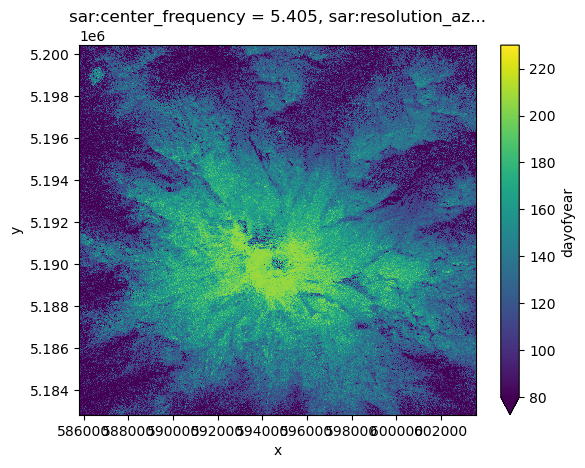

In [13]:
runoff_2020_DOY.plot(vmin=80,vmax=230)

## What if we wanted to mask out trees, built-up areas, and water bodies? Use worldcover classification to mask ts_ds:

In [14]:
classes = [ # page 13 of https://esa-worldcover.s3.amazonaws.com/v100/2020/docs/WorldCover_PUM_V1.0.pdf
#    10, # treecover
    20, # shrubland
    30, # grassland
    40, # cropland
#    50, # built-up
    60, #bare / sparse vegetation
    70, # snow and ice
#    80, # permanent water bodies
    90, # herbaceous wetlands
    95, # mangroves
    100 # loss and lichen
]

In [15]:
worldcover = s1_rtc_bs_utils.get_worldcover(ts_ds)

/srv/conda/envs/notebook/lib/python3.11/site-packages/pystac_client/item_search.py:826: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(


In [16]:
ts_ds_masked = ts_ds.where(worldcover.isin(classes))

## Now repeat the usual steps:

In [17]:
ts_ds_masked_2020 = ts_ds_masked.sel(time=melt_season)

In [18]:
runoff_masked_2020 = s1_rtc_bs_utils.get_runoff_onset(ts_ds_masked_2020,num_acquisitions_during_melt_season=6)

In [19]:
runoff_masked_2020_DOY = runoff_masked_2020.dt.dayofyear

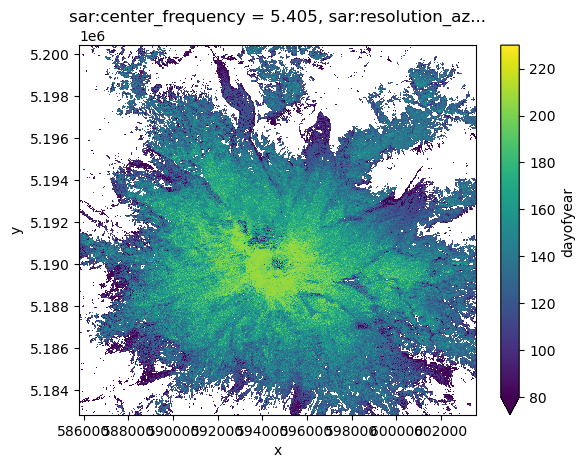

In [20]:
runoff_masked_2020_DOY.plot(vmin=80,vmax=230)

## What if we want runoff onset from 2015-2023?

In [21]:
years = [2015,2016,2017,2018,2019,2020,2021,2022,2023]

In [22]:
if not os.path.exists(f'example_images/'):
    os.makedirs(f'example_images/')

In [23]:
for year in years:
    print(f'Processing {year}')
    melt_season =  slice(f'{year}-02-01',f'{year}-08-01')
    
    if (year == 2015) | (year == 2016): # 2015 and 2016 VH coverage is sporadic
        ts_ds_oneyear = ts_ds.sel(time=melt_season).sel(band='vv')
    else:
        ts_ds_oneyear = ts_ds.sel(time=melt_season)
        
    ts_ds_masked_oneyear = ts_ds_oneyear.where(worldcover.isin(classes))
    runoff_onset_masked = s1_rtc_bs_utils.get_runoff_onset(ts_ds_masked_oneyear,num_acquisitions_during_melt_season=6)
    runoff_onset_masked_DOY = runoff_onset_masked.dt.dayofyear
    runoff_onset_masked_DOY.where(runoff_onset_masked_DOY>0).rio.write_nodata(-32768,encoded=True).rio.to_raster(f'example_images/runoff_onset_{year}.tif',driver="COG",dtype='int16')

Processing 2015
Processing 2016
Processing 2017
Processing 2018
Processing 2019
Processing 2020
Processing 2021
Processing 2022
Processing 2023


## Let's visualize all years

In [24]:
geotiff_list = glob.glob(f'example_images/runoff_onset_*.tif')
year_list = []

for geotiff in geotiff_list:
    year_list.append(re.search("([0-9]{4})", geotiff).group(0))
    year_list = [int(year) for year in year_list]

#Create variable used for time axis
time_var = xr.Variable('time', year_list)

# Load in and concatenate all individual GeoTIFFs
runoff_allyears = xr.concat([rxr.open_rasterio(i,masked=True) for i in geotiff_list],dim=time_var).squeeze().sortby('time')

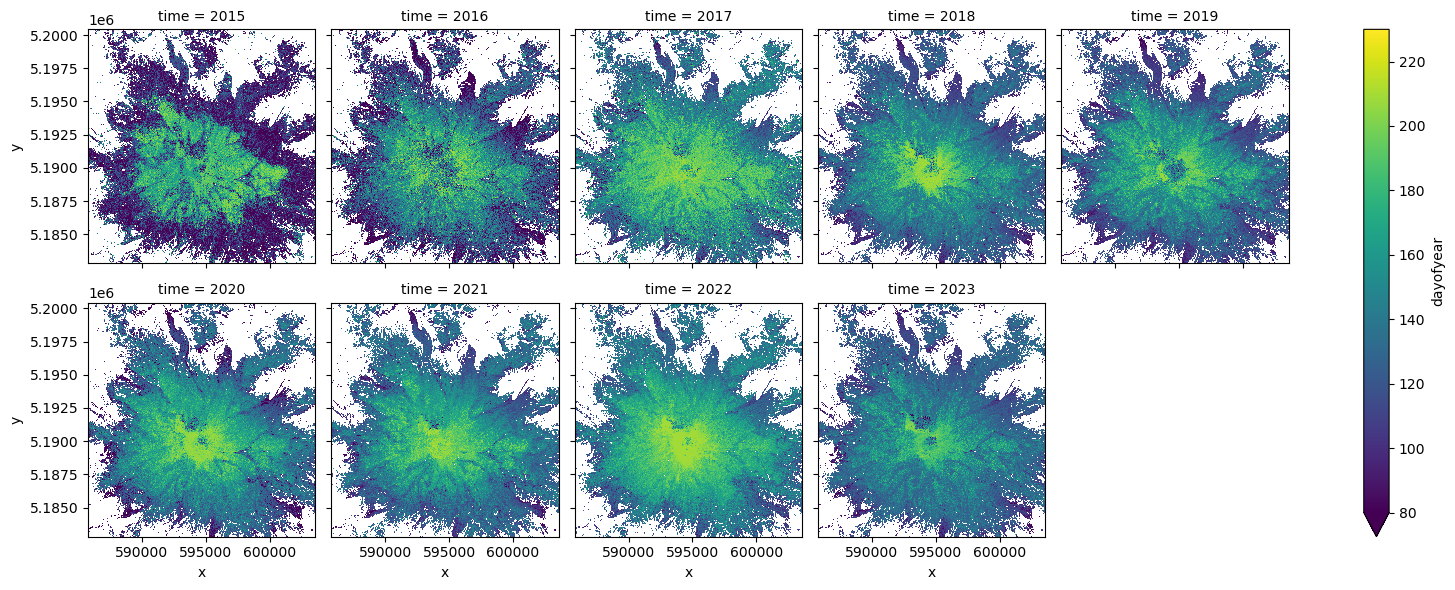

In [25]:
runoff_allyears.plot(col='time',col_wrap=5,vmin=80,vmax=230)

## Finally let's take calculate and visualize a 2015-2023 median snowmelt runoff onset map

In [26]:
runoff_allyears_median = runoff_allyears.median(dim='time')

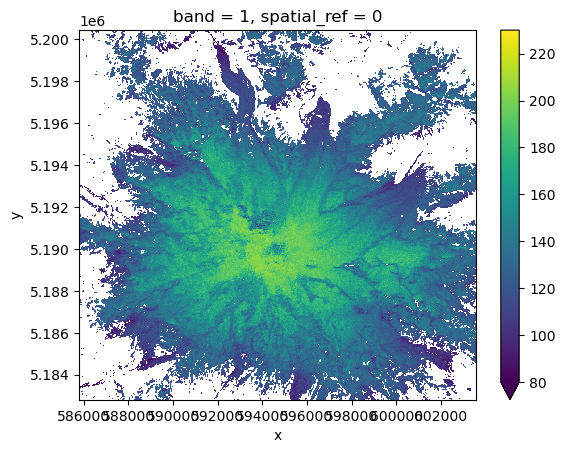

In [27]:
runoff_allyears_median.plot(vmin=80,vmax=230)

## Check out the binary_wet_snow_map_timeseries.ipynb notebook for binary wet snow maps!